In [1]:
# Implementing a U-net network on Bagls dataset.

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from natsort import natsorted

import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler
# from keras import backend as keras
# import tensorflow as tf
import albumentations as A
from PIL import Image
from sklearn.model_selection import train_test_split


In [6]:
In [1]: data_dir = 'D:/Hamed/Forschungsproject/Hancock 2/tiles3'
 
x = []
y = []

for filename in natsorted(os.listdir(data_dir)):
    if filename.endswith('].png'):
        x.append(os.path.join(data_dir, filename))

    if filename.endswith('labelled.png'):
        y.append(os.path.join(data_dir, filename))

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.01, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)
overfit_X_train , overtfit_Y_train = X_train[0:5] , Y_train[0:5]

In [7]:
print("Dataset Sizes:")
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")


Dataset Sizes:
Training set: 5511 samples
Validation set: 613 samples
Test set: 62 samples


(256, 256)


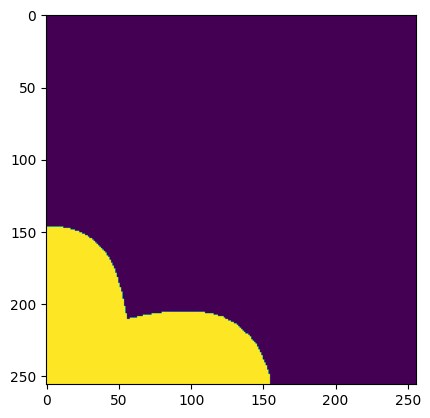

In [22]:
lbl_arr = Image.open(Y_train[np.random.randint(0,len(Y_train))])
lbl_arr = lbl_arr.resize((256, 256))
lbl_arr = np.array(lbl_arr)
print(np.shape(lbl_arr))
plt.imshow(lbl_arr)


In [23]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, list_IDs, list_labels, batch_size=2, shuffle=True, aug=True):
        'Initialization'
        self.filter = A.Compose([
            A.HorizontalFlip(p=0.2),
            A.RandomBrightnessContrast(p=0.2),
            A.VerticalFlip(p=0.2),
            A.RandomRotate90(p=0.1)
        ])
        self.batch_size = batch_size
        self.list_labels = list_labels
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.aug = aug
        self.unique = np.arange(1, 13, 1)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_paths = [self.list_IDs[k] for k in indexes]
        list_label_paths = [self.list_labels[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_paths, list_label_paths)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_paths, list_label_paths):
        'Generates data containing batch_size samples' # X: (n_samples, *dim, n_channels)
        # Initialization
        x_images = []
        y_images = []

        # Generate data
        for i, (sample_path, label_path) in enumerate(zip(list_IDs_paths, list_label_paths)):
            # Store sample
            img_arr = Image.open(sample_path)
            img_arr = img_arr.resize((256, 256))
            img_arr = np.array(img_arr, dtype=np.float32)
            img_arr = np.divide(img_arr, np.max(img_arr))  # normalize

            # Store label
            lbl_arr = Image.open(label_path)
            lbl_arr = lbl_arr.resize((256, 256))
            lbl_arr = np.array(lbl_arr)
            channels = np.zeros((np.shape(lbl_arr)[0], np.shape(lbl_arr)[1], 12), dtype=np.float32)

            bg = np.zeros((np.shape(lbl_arr)[0], np.shape(lbl_arr)[1]))

            for i, value in enumerate(self.unique):
                channels[:, :, i] = (lbl_arr == value).astype(np.uint8) * 255

            bg = (lbl_arr == 0)
            lbl_arr = channels

            lbl_arr[lbl_arr < 1] = 0
            lbl_arr[lbl_arr >= 1] = 1

            if self.aug:
                transformed = self.filter(image=img_arr, mask=lbl_arr)
                x_images.append(transformed['image'])
                y_images.append(transformed['mask'])
            else:
                x_images.append(img_arr)
                y_images.append(lbl_arr)

        # Stack x_images along a new axis
        x_images = np.stack(x_images, axis=0)
        y_images = np.stack(y_images, axis=0)

        return x_images, y_images

    def viz(self, x_images, y_images):
        'Visualizes original and transformed images'
        batch_size = len(x_images)
        for dx in range(batch_size):
            y_mask = y_images[dx]

            # Display original and transformed images side by side
            fig, axs = plt.subplots(1, 13, figsize=(20, 10))

            axs[0].imshow(x_images[dx])
            axs[0].set_title('img')
            axs[0].axis('off')

            for i in range(1, 13):
                axs[i].imshow(y_mask[:, :, i - 1], cmap='gray')
                axs[i].axis('off')  # Remove axes
                axs[i].set_title(f'Class {i}')
            plt.show()

        print(f'Batch shape {np.shape(x_images)} and for masks {np.shape(y_images)}')
        print(f'image shape {np.shape(x_images[dx])} and for masks {np.shape(y_images[dx])}')
        print(f'max value for images is {np.max(x_images[dx])} and for masks {np.max(y_images[dx])}')
        print(f'min value for images is {np.min(x_images[dx])} and for masks {np.min(y_images[dx])}')
        print(f'number of unique values in images is {len(np.unique(x_images[dx]))} and for masks {np.unique(y_images[dx])}')


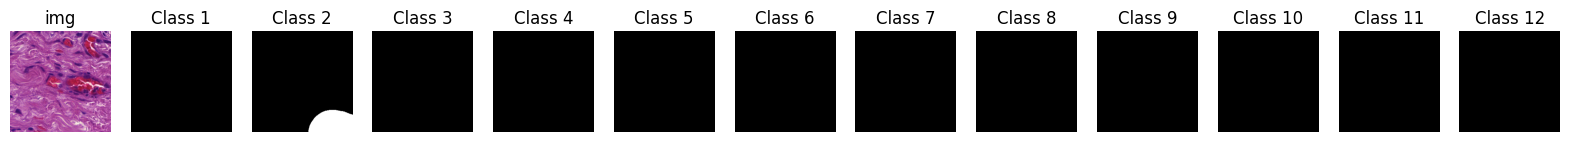

Batch shape (1, 256, 256, 3) and for masks (1, 256, 256, 12)
image shape (256, 256, 3) and for masks (256, 256, 12)
max value for images is 1.0 and for masks 1.0
min value for images is 0.003921568859368563 and for masks 0.0
number of unique values in images is 253 and for masks [0. 1.]


In [31]:
test = DataGenerator(x,y,batch_size=1,aug=0)
a,b = test.__getitem__(50)
test.viz(a,b)

In [36]:

fil = 32
inputs = Input((256, 256,3))


# Contractive
conv1 = Conv2D(fil, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(fil, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(fil*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(fil*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(fil*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(fil*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(fil*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(fil*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
conv4 = BatchNormalization()(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(fil*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(fil*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
conv5 = BatchNormalization()(conv5)

# Expansive
upconv1 = Conv2D(fil*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
up6 = UpSampling2D(size = (2,2))(upconv1)
merge6 = concatenate([conv4,up6], axis = 3)
conv6 = Conv2D(fil*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(fil*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
conv6 = BatchNormalization()(conv6)

upconv2 = Conv2D(fil*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
up7 = UpSampling2D(size = (2,2))(upconv2)
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(fil*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(fil*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
conv7 = BatchNormalization()(conv7)

upconv3 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
up8 = UpSampling2D(size = (2,2))(upconv3)
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(fil*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(fil*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
conv8 = BatchNormalization()(conv8)


upconv4 = Conv2D(fil*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
up9 = UpSampling2D(size = (2,2))(upconv4)
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(fil, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(fil, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = BatchNormalization()(conv9)


conv10 = Conv2D(12, 1, activation = 'softmax')(conv9)

model = Model(inputs = inputs, outputs = conv10)

#model.summary()




In [18]:
from keras.callbacks import EarlyStopping

earlystop_callback = EarlyStopping(
    monitor='loss', 
    min_delta=0.0001,
    patience=5,
    verbose=1, 
    mode='auto' 
)

from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import IOUScore

loss = DiceLoss()
metric = IOUScore()

def custom_loss(y_true, y_pred):
    y_true_exclude_first = y_true[:, :, :, 1:]
    y_pred_exclude_first = y_pred[:, :, :, 1:]
    return loss(y_true_exclude_first, y_pred_exclude_first)

# Define custom metric excluding the first channel
def custom_metric(y_true, y_pred):
    y_true_exclude_first = y_true[:, :, :, 1:]
    y_pred_exclude_first = y_pred[:, :, :, 1:]
    return metric(y_true_exclude_first, y_pred_exclude_first)


Segmentation Models: using `keras` framework.


In [33]:
from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import IOUScore

DiceLoss = DiceLoss()
IOUscore = IOUScore()

In [35]:
model.compile(optimizer=Adam(learning_rate=0.1,),
              loss=DiceLoss,
              metrics=[IOUscore])

history = model.fit(DataGenerator(X_train, Y_train, batch_size=32),
                    epochs=5,
                    callbacks=earlystop_callback,
                    validation_data=DataGenerator(X_val, Y_val, batch_size=32))


Epoch 1/5
172/172 [==============================] - 108s 618ms/step - loss: 0.8875 - iou_score: 0.0850 - val_loss: 0.9753 - val_iou_score: 0.0131
Epoch 2/5
172/172 [==============================] - 105s 609ms/step - loss: 0.8555 - iou_score: 0.1236 - val_loss: 0.8419 - val_iou_score: 0.1455
Epoch 3/5
172/172 [==============================] - 107s 624ms/step - loss: 0.7467 - iou_score: 0.2309 - val_loss: 0.7469 - val_iou_score: 0.2349
Epoch 4/5
172/172 [==============================] - 105s 611ms/step - loss: 0.7417 - iou_score: 0.2374 - val_loss: 0.7456 - val_iou_score: 0.2355
Epoch 5/5
 71/172 [===========>..................] - ETA: 57s - loss: 0.7370 - iou_score: 0.2440

KeyboardInterrupt: 

In [ ]:
of = DataGenerator(overfit_X_train, overtfit_Y_train, batch_size=3, aug=True)
ofx, ofy = of.__getitem__(0)
of.viz(ofx, ofy)

In [104]:
# overfitting
from tensorflow_addons.optimizers import AdamW

model.compile(optimizer=Adam(learning_rate=0.1), loss=DiceLoss, metrics=[IOUscore])

history = model.fit(ofx, ofy, epochs=300)


Epoch 1/30
1/1 [==============================] - 1s 1s/step - loss: 0.9887 - custom_metric: 0.0061
Epoch 2/30
1/1 [==============================] - 0s 27ms/step - loss: 0.9867 - custom_metric: 0.0072
Epoch 3/30
1/1 [==============================] - 0s 32ms/step - loss: 0.9856 - custom_metric: 0.0079
Epoch 4/30
1/1 [==============================] - 0s 29ms/step - loss: 0.9849 - custom_metric: 0.0083
Epoch 5/30
1/1 [==============================] - 0s 36ms/step - loss: 0.9842 - custom_metric: 0.0087
Epoch 6/30
1/1 [==============================] - 0s 40ms/step - loss: 0.9835 - custom_metric: 0.0092
Epoch 7/30
1/1 [==============================] - 0s 44ms/step - loss: 0.9829 - custom_metric: 0.0095
Epoch 8/30
1/1 [==============================] - 0s 42ms/step - loss: 0.9824 - custom_metric: 0.0098
Epoch 9/30
1/1 [==============================] - 0s 41ms/step - loss: 0.9820 - custom_metric: 0.0101
Epoch 10/30
1/1 [==============================] - 0s 27ms/step - loss: 0.9816 - cus

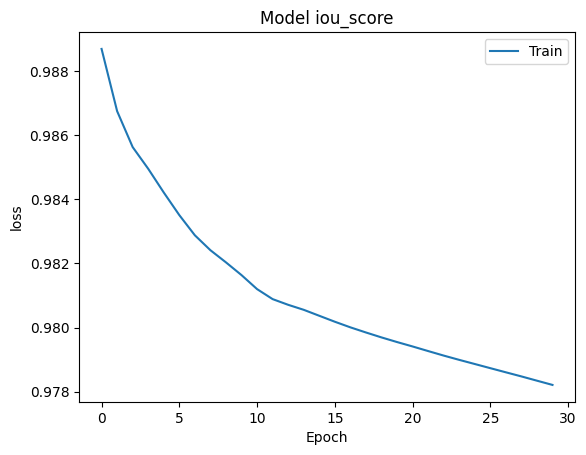

In [109]:
#how was the network on each epoch?

plt.plot(history.history['loss'])
plt.title('Model iou_score')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [111]:
DataGen = DataGenerator(X_test, Y_test, batch_size=len(X_test),aug=True)
a, b =DataGen.__getitem__(0)
score = model.evaluate(a,b)


1/1 [==============================] - 0s 54ms/step - loss: 0.9727 - custom_metric: 0.0145


In [20]:
# Normal
DataGen = DataGenerator(X_test, Y_test, batch_size=1, aug=True)
img, mask = DataGen.__getitem__(0)
score = model.evaluate(img, mask)
y_pred = model.predict(img)

# Create a figure with three subplots arranged horizontally
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the input image in the first subplot
axs[0].imshow(img[0])
axs[0].set_title('Input image')

# Create an empty array to store the changed image
changed_img = np.zeros((12, 256, 256, 1), dtype=np.uint8)

# Iterate over the channels and assign values accordingly
for i in range(12):
    temp = (mask[:, :, :, i] == 1.).astype(np.uint8)
    changed_img[:, :, :, 0] += temp * (i + 1)


# Plot the ground truth output in the second subplot
im = axs[1].imshow(np.sum(mask[0], axis=2))
axs[1].set_title('Ground truth output')
plt.colorbar(im, ax=axs[1])

##################################

# Create the subplots
fig, axs = plt.subplots(1, 12, figsize=(15, 5))

# Loop through each subplot
for i, ax in enumerate(axs.flat):
    ax.imshow(mask[0][:, :, i])
    ax.axis('off')
    ans = np.mean(mask[0][:, :, i])
    ax.set_title(f'p(y{i+1}) = {ans:.2f}', fontsize=8)

plt.show()

###########################################

# Create the subplots
fig, axs = plt.subplots(1, 12, figsize=(15, 5))

# Loop through each subplot
for i, ax in enumerate(axs.flat):
    ax.imshow(y_pred[0][:, :, i])
    ax.axis('off')
    ans = np.mean(y_pred[0][:, :, i])
    ax.set_title(f'p(y{i+1}) = {ans:.2f}', fontsize=8)

plt.show()


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
In [1]: # Over fitted
   ...: 
   ...: 
   ...: j = 2
   ...: y_pred = model.predict(ofx[j:j+1])
   ...: img = ofx[j:j+1]
   ...: mask = ofy[j:j+1]
   ...: 
   ...: # Create a figure with three subplots arranged horizontally
   ...: fig, axs = plt.subplots(1, 2, figsize=(10, 5))
   ...: 
   ...: # Plot the input image in the first subplot
   ...: axs[0].imshow(img[0])
   ...: axs[0].set_title('Input image')
   ...: 
   ...: # Create an empty array to store the changed image
   ...: changed_img = np.zeros((12, 256, 256, 1), dtype=np.uint8)
   ...: 
   ...: # Iterate over the channels and assign values accordingly
   ...: for i in range(12):
   ...:     temp = (mask[:,:, :, i] == 1.).astype(np.uint8)
   ...:     changed_img[:, :, :, 0] += temp * (i + 1)
   ...: 
   ...: 
   ...: # Plot the ground truth output in the second subplot
   ...: axs[1].imshow(np.sum(mask[0],axis=2))
   ...: axs[1].set_title('Ground truth output')
   ...: 
   ...: ##################################
   ...: # Create the subplots
   ...: fig, axs = plt.subplots(1, 12,figsize=(15, 5))
   ...: 
   ...: # Loop through each subplot
   ...: for i, ax in enumerate(axs.flat):
   ...:     ax.imshow(mask[0][:, :, i])
   ...:     ax.axis('off')
   ...:     ans = np.mean(mask[0][:, :, i])
   ...:     ax.set_title(f'p(y{i+1}) = {ans:.2f}', fontsize=8)
   ...: 
   ...: plt.show()
   ...: 
   ...: ###########################################
   ...: # Create the subplots
   ...: fig, axs = plt.subplots(1, 12,figsize=(15, 5))
   ...: 
   ...: # Loop through each subplot
   ...: for i, ax in enumerate(axs.flat):
   ...:     ax.imshow(y_pred[0][:, :, i])
   ...:     ax.axis('off')
   ...:     ans = np.mean(y_pred[0][:, :, i])
   ...:     ax.set_title(f'p(y{i+1}) = {ans:.2f}', fontsize=8)
   ...: 
   ...: plt.show()